This code belongs to [this section](https://developers.google.com/machine-learning/crash-course/validation/programming-exercise).

## Import modules

In [1]:
import numpy as np
import pandas as pd

import torch
from sklearn.linear_model import LinearRegression

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Define helper functions
These are the same functions used in `1_linear_regression`.

In [4]:
class LinearRegressionModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(1, 1)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    return train_step


def plot_model(x, y, slope, intercept, losses, val_losses):
    # Scatter plot
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    sns.regplot(x, y, ax=ax[0])
    ax[0].axhline(y=0, color='k', linewidth=1)
    ax[0].axvline(x=0, color='k', linewidth=1)

    # Regression line
    x_pred = np.linspace(x.min() - 0.2, x.max() + 0.2, 50)
    y_pred = (x_pred * slope) + intercept
    sns.lineplot(x=x_pred, y=y_pred, ax=ax[0])
    
    # Loss curve
    losses_df = pd.DataFrame({
        "Epoch": np.linspace(0, epochs, len(losses)),
        "Loss": losses
    })
    losses_df["Type"] = ["Training Loss"] *  losses_df.shape[0]
    
    val_losses_df = pd.DataFrame({
        "Epoch": np.linspace(0, epochs, len(val_losses)),
        "Loss": val_losses
    })
    val_losses_df["Type"] = ["Validation Loss"] *  val_losses_df.shape[0]
    
    sns.lineplot(x="Epoch", y="Loss", data=losses_df.append(val_losses_df),
                 ax=ax[1], hue="Type")

In [5]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

class CustomDataset(Dataset):
    def __init__(self, df, x_col, y_col):
        self.x = torch.from_numpy(df[x_col].values.reshape(-1, 1)).float()
        self.y = torch.from_numpy(df[y_col].values.reshape(-1, 1)).float()
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

## Load the dataset

In [6]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

train_df["median_house_value"] /= 1000.0
test_df["median_house_value"] /= 1000.0

In [7]:
# The following variables are the hyperparameters.
learning_rate = 0.08
epochs = 40
batch_size = 100
validation_split = 0.2

# Specify the feature and the label.
my_feature = "median_income"  # the total number of rooms on a specific city block.
my_label="median_house_value" # the median value of a house on a specific city block.

In [8]:
from barbar import Bar
from IPython.display import clear_output

# Discard any pre-existing version of the model.
my_model = None

# Create Dataset to hold the training data
# Note that we shuffled the training set to avoid patterns
shuffled_train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
dat = CustomDataset(shuffled_train_df, my_feature, my_label)

# Split the dataset into a training set and a validation set
validation_set_size = int(train_df.shape[0] * validation_split)
training_set_size = train_df.shape[0] - validation_set_size
train_dataset, val_dataset = random_split(dat, [training_set_size, validation_set_size])

# The batch sizes don't have to be equal!
# In practice the validation batch size could be larger because we don't have to update
# the gradients, and more GPU memory is available.
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=2*batch_size, shuffle=True)

Instead of the vanilla mini-batch gradient descent, we use RMSprop, an adaptive learning rate algorithm. See an overview of gradient descent algorithms [here](https://ruder.io/optimizing-gradient-descent/).

In [9]:
# Define the model
torch.manual_seed(42)
my_model = LinearRegressionModel().to(device)
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(my_model.parameters(), lr = learning_rate)
optimizer = torch.optim.RMSprop(my_model.parameters(), lr = learning_rate)

# Train model
losses = []
val_losses = []
train_step = make_train_step(my_model, criterion, optimizer)

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")

    last_epoch_loss = 0.0
    for _, (x_batch, y_batch) in enumerate(Bar(train_loader)):
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        last_epoch_loss += loss
    last_epoch_loss /= len(train_loader)
    
    last_epoch_val_loss = 0.0
    # context manager to disable any gradient calculation
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            my_model.eval()

            yhat = my_model(x_val)
            val_loss = criterion(y_val, yhat).item()
            val_losses.append(val_loss)
            last_epoch_val_loss += val_loss
    last_epoch_val_loss /= len(val_loader)
    
    clear_output(wait=True)
    print(f"Loss (MSE): {last_epoch_loss :.4f}\nValidation loss: {last_epoch_val_loss: .4f}")

Loss (MSE): 7039.9482
Validation loss:  6916.8036


The predicted model is: y =  42.155x +  44.610
The sklearn model is: y =  42.054x +  43.981


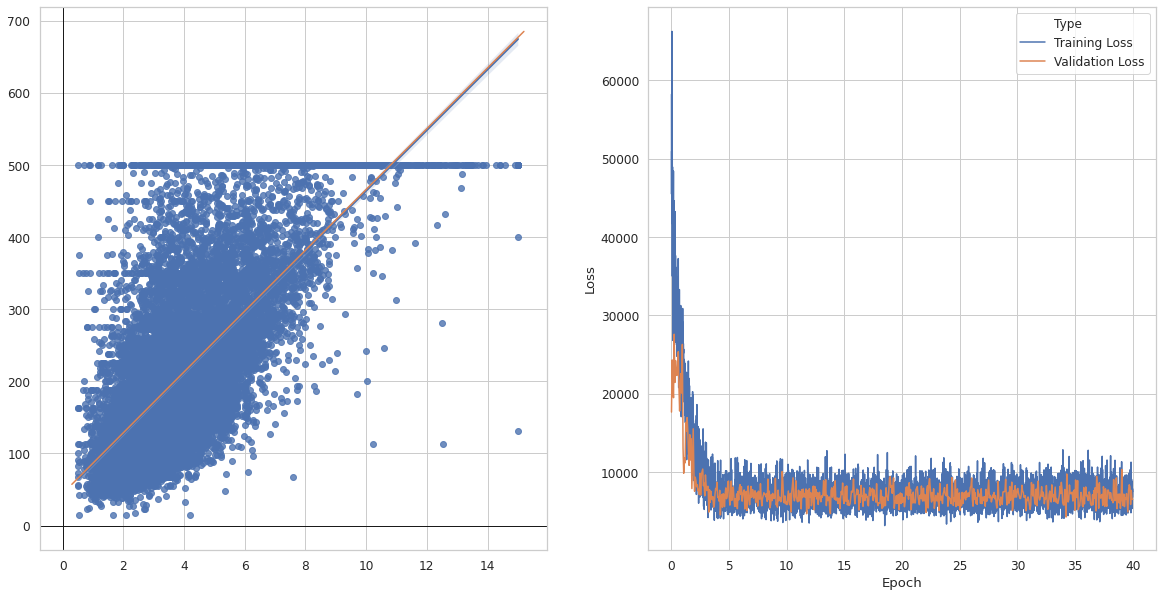

In [10]:
model_beta_0 = my_model.state_dict()["linear.bias"].item()
model_beta_1 = my_model.state_dict()["linear.weight"].item()
print(f"The predicted model is: y = {model_beta_1: .3f}x + {model_beta_0: .3f}")

# Fit SLR model to check how far off we are
x = train_df[my_feature].values
y = train_df[my_label].values
reg = LinearRegression().fit(x.reshape(-1, 1), y.reshape(-1, 1))
print(f"The sklearn model is: y = {reg.coef_[0][0]: .3f}x + {reg.intercept_[0]: .3f}")

plot_model(x, y, model_beta_1, model_beta_0, losses, val_losses)

Ideally the loss for the training set and the validation set should be very close in the end. 

In [11]:
# Evaluate the model with the test set
dat_test = CustomDataset(test_df, my_feature, my_label)
test_loader = DataLoader(dataset=dat_test, batch_size=batch_size, shuffle=True)

test_losses = []
with torch.no_grad():
    for x_val, y_val in test_loader:
        x_val = x_val.to(device)
        y_val = y_val.to(device)

        my_model.eval()

        yhat = my_model(x_val)
        test_loss = criterion(y_val, yhat)
        test_losses.append(test_loss.item())

print(f"The loss for the test set is {np.array(test_losses).mean() :.4f}")

The loss for the test set is 7008.1514
